# MC REINFORCE

In [108]:
#required imports
import argparse
import matplotlib.pyplot as plt
import gym
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

## MC REINFORCE without baseline
The below code sets up the neural network for the policy

In [183]:
class MC_REINFORCE_WO_BL(nn.Module):
    def __init__(self):
        #initialization of layers of nn
        super(MC_REINFORCE_WO_BL, self).__init__()
        self.hidden= nn.Linear(OBS_DIM, 128)
        self.action_head = nn.Linear(128,ACTION_DIM)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        #forward of the policy network
        x = F.relu(self.hidden(x))
        action_prob = F.softmax(self.action_head(x), dim=-1)

        #returns the probabilites of the actions
        return action_prob

## Action selection and Network updation

In [184]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs= model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append(m.log_prob(action))

    # the action to take
    return action.item()


def finish_episode():
    #calculates policy loss and performs backprop
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save policy loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + gamma * R
        returns.insert(0, R)

    #normalizing returns
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for log_prob, R in zip(saved_actions, returns):

        # calculate  policy loss
        policy_losses.append(-log_prob * R)

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]

#the training function
def train():
    running_reward = min_reward

    # run infinitely many episodes
    for i_episode in range(ep_num):

        # reset environment and episode reward
        state = env.reset()
        ep_reward = 0

        # for each episode, only run 9999 steps so that we don't
        # infinite loop while learning
        for t in range(1, 10000):

            # select action from policy
            action = select_action(state)

            # take the action
            state, reward, done, _ = env.step(action)

            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        reward_arr[i_episode]=ep_reward
        # update cumulative reward
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        reward_running_avg[i_episode]=running_reward
        # perform backprop
        finish_episode()

        # log results
        if i_episode % log_interval == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))


## Plotter for regret,  rewards, and filtered rewards

In [180]:
def plot_MC_both(regrets_list1, scores_list1,running_avg1,regrets_list2,scores_list2,running_avg2):
  r_mean_values1 = np.mean(regrets_list1, axis=0)
  r_std_dev1 = np.std(regrets_list1, axis=0)
  s_mean_values1 = np.mean(scores_list1, axis=0)
  s_std_dev1 = np.std(scores_list1, axis=0)
  a_mean1=np.mean(running_avg1,axis=0)
  a_std1=np.std(running_avg1,axis=0)
  r_mean_values2 = np.mean(regrets_list2, axis=0)
  r_std_dev2 = np.std(regrets_list2, axis=0)
  s_mean_values2 = np.mean(scores_list2, axis=0)
  s_std_dev2 = np.std(scores_list2, axis=0)
  a_mean2=np.mean(running_avg2,axis=0)
  a_std2=np.std(running_avg2,axis=0)
  x = np.arange(ep_num)
  t=[max_reward]*ep_num

  #plots regret
  plt.figure()
  plt.plot(x, r_mean_values1, color='blue', linestyle='-', label='MC without baseline')
  plt.fill_between(x, r_mean_values1 - r_std_dev1, r_mean_values1 + r_std_dev1, color='lightblue', label='± 1 Std Dev')
  plt.plot(x, r_mean_values2, color='red', linestyle='-', label='MC with baseline')
  plt.fill_between(x, r_mean_values2 - r_std_dev2, r_mean_values2 + r_std_dev2, color='mistyrose', label='± 1 Std Dev')
  plt.xlabel('Episode')
  plt.ylabel('Regret')
  plt.legend()
  plt.grid(True)
  plt.show()

  #plots rewards
  plt.figure()
  plt.plot(x, s_mean_values1, color='blue', linestyle='-', label='MC without baseline')
  plt.fill_between(x, s_mean_values1 - s_std_dev1, s_mean_values1 + s_std_dev1, color='lightblue')
  plt.plot(x, s_mean_values2, color='red', linestyle='-', label='MC with baseline')
  plt.fill_between(x, s_mean_values2 - s_std_dev2, s_mean_values2 + s_std_dev2, color='mistyrose')
  plt.plot(x,t,color='green',linestyle='-',label='Threshold')
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.legend()
  plt.grid(True)
  plt.show()

  #plots running average rewards
  plt.figure()
  plt.plot(x, a_mean1, color='blue', linestyle='-', label='MC without_baseline')
  plt.fill_between(x, a_mean1 - a_std1, a_mean1 + a_std1, color='lightblue')
  plt.plot(x, a_mean2 , color='red', linestyle='-', label='MC with baseline')
  plt.fill_between(x, a_mean2 - a_std2, a_mean2 + a_std2, color='mistyrose')
  plt.plot(x,t,color='green',linestyle='-',label='Threshold')
  plt.xlabel('Episode')
  plt.ylabel('Running Reward')
  plt.legend()
  plt.grid(True)
  plt.show()

### Training the agent on the CARTPOLE environment

In [66]:
#parameters
OBS_DIM=4
ACTION_DIM=2
log_interval = 10
gamma = 0.99
ep_num=600
min_reward=10
max_reward=475
seed_num=5
seed_list =[0,1,3,4,5]
eps=1e-6

env = gym.make('CartPole-v1')
reward_avg_wbl_cp=np.zeros((seed_num,ep_num))
regret_avg_wbl_cp=np.zeros((seed_num,ep_num))
reward_running_avg_wbl_cp=np.zeros((seed_num,ep_num))
#averaging over 5 seeds
for i in range(len(seed_list)):
  model = MC_REINFORCE_WO_BL()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  env.reset(seed=seed_list[i])
  torch.manual_seed(seed_list[i])
  reward_arr=np.zeros(ep_num)
  reward_running_avg=np.zeros(ep_num)
  train()
  reward_running_avg_wbl_cp[i]=reward_running_avg
  reward_avg_wbl_cp[i]=reward_arr
  regret_avg_wbl_cp[i]=max_reward-reward_arr



### Training the agent on the ACROBOT environment

In [114]:
#parameters
Hidden_size=128
OBS_DIM=6
ACTION_DIM=3
log_interval = 10
gamma = 0.99
ep_num=600
min_reward=-500
max_reward=0
seed_num=5
seed_list =[0,1,3,4,5]
eps=1e-6

env = gym.make('Acrobot-v1')
reward_avg_wbl_ab=np.zeros((seed_num,ep_num))
regret_avg_wbl_ab=np.zeros((seed_num,ep_num))
reward_running_avg_wbl_ab=np.zeros((seed_num,ep_num))
#averaging over 5 seeds
for i in range(len(seed_list)):
  model = MC_REINFORCE_WO_BL()
  optimizer = optim.Adam(model.parameters(), lr=0.002)
  env.reset(seed=seed_list[i])
  torch.manual_seed(seed_list[i])
  reward_arr=np.zeros(ep_num)
  reward_running_avg=np.zeros(ep_num)
  train()
  reward_running_avg_wbl_ab[i]=reward_running_avg
  reward_avg_wbl_ab[i]=reward_arr
  regret_avg_wbl_ab[i]=max_reward-reward_arr

## Policy Gradient: (MC REINFORCE WITH BASELINE)

### Setting up the neural network for both the value function(baseline) and the policy

In [128]:
class MC_REINFORCE_W_BL(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(MC_REINFORCE_W_BL, self).__init__()
        self.hidden = nn.Linear(OBS_DIM, 128)

        #policy layer
        self.action_head = nn.Linear(128, ACTION_DIM)

        # value function layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.hidden(x))

        # policy layer choses action to take from state s_t
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # return value of a state
        state_values = self.value_head(x)

        # return values for both policy and value function as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t
        return action_prob, state_values


In [130]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append((m.log_prob(action), state_value))

    # the action to take
    return action.item()


def finish_episode():
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save policy loss
    value_losses = [] # list to save critic value loss
    returns = [] # list to save the true values
    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate  policy loss
        policy_losses.append(-log_prob * advantage)

        # calculate  value loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()
    # sum up all the values of policy_losses and value_losses
    loss= torch.stack(policy_losses).sum()+torch.stack(value_losses).sum()
    # perform backprop
    loss.backward()
    optimizer.step()
    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]

### Training the agent on the CARTPOLE environment

In [83]:
#parameters
OBS_DIM=4
ACTION_DIM=2
log_interval = 10
gamma = 0.99
ep_num=600
max_reward=500
min_reward=10
seed_num=5
seed_list =[0,1,3,4,5]
eps=1e-6

env = gym.make('CartPole-v1')
reward_avg_bl_cp=np.zeros((seed_num,ep_num))
regret_avg_bl_cp=np.zeros((seed_num,ep_num))
reward_running_avg_bl_cp=np.zeros((seed_num,ep_num))
#averaging over 5 seeds
for i in range(len(seed_list)):
  model = MC_REINFORCE_W_BL()
  optimizer= optim.Adam(model.parameters(), lr=0.002)
  env.reset(seed=seed_list[i])
  torch.manual_seed(seed_list[i])
  reward_arr=np.zeros(ep_num)
  reward_running_avg=np.zeros(ep_num)
  train()
  reward_running_avg_bl_cp[i]=reward_running_avg
  reward_avg_bl_cp[i]=reward_arr
  regret_avg_bl_cp[i]=max_reward-reward_arr

### Training on the ACROBOT environment

In [171]:
#parameters
Hidden_size=128
OBS_DIM=6
ACTION_DIM=3
log_interval = 10
gamma = 0.99
ep_num=600
min_reward=-500
max_reward=0
seed_num=5
seed_list =[5,3,6,1,4]
eps=1e-6

env = gym.make('Acrobot-v1')
reward_avg_bl_ab=np.zeros((seed_num,ep_num))
regret_avg_bl_ab=np.zeros((seed_num,ep_num))
reward_running_avg_bl_ab=np.zeros((seed_num,ep_num))

#averaging over 5 seeds
for i in range(len(seed_list)):
  model = MC_REINFORCE_W_BL()
  optimizer = optim.Adam(model.parameters(), lr=0.002)
  env.reset(seed=seed_list[i])
  torch.manual_seed(seed_list[i])
  reward_arr=np.zeros(ep_num)
  reward_running_avg=np.zeros(ep_num)
  train()
  reward_running_avg_bl_ab[i]=reward_running_avg
  reward_avg_bl_ab[i]=reward_arr
  regret_avg_bl_ab[i]=max_reward-reward_arr

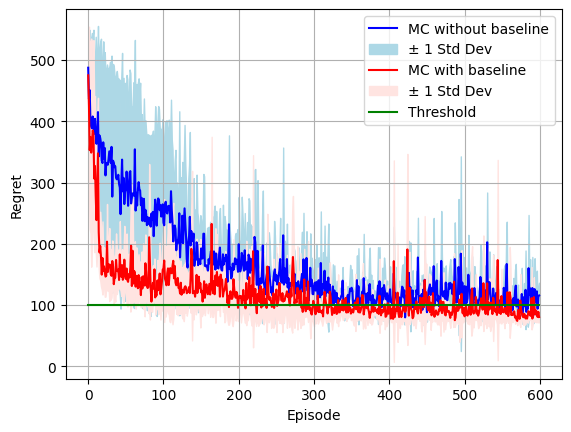

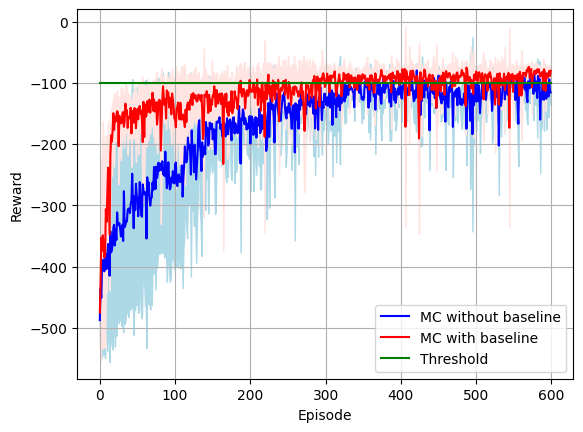

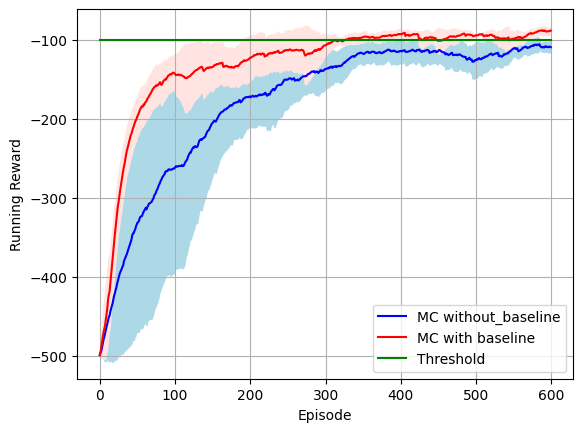

In [197]:
plot_MC_both(regret_avg_wbl_ab,reward_avg_wbl_ab,reward_running_avg_wbl_ab,regret_avg_bl_ab,reward_avg_bl_ab,reward_running_avg_bl_ab)